<a href="https://colab.research.google.com/github/YonggunJung/Project1-KOSPI/blob/main/%EC%96%91%EB%B0%A9%ED%96%A5_LSTM_vs_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

# 경고 뜨지 않게..
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 모듈
import random

# 학습 모델 저장 및 복원
import pickle

# 딥러닝 라이브러리
import tensorflow as tf
# 신경망 모델을 관리하는 객체
from tensorflow.keras.models import Sequential
# 선형 회귀 레이어
from tensorflow.keras.layers import Dense
# 활성화 함수를 정의하는 객체
from tensorflow.keras.layers import Activation
# CNN : 커널을 통해 합성곱을 구하는 것, 이미지의 특징이 두드러지게 한다.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
# MaxPooling : 커널내에서 가장 큰 값을 추출하는 방식으로 불필요한 부분을 제거한다., 값이 작은부분은 빠져버린다
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import MaxPool1D
# Flatten : 다차원의 이미지 데이터를 선형회귀 은닉층으로 전달하기 전에
# 1차원으로 변환하는것
from tensorflow.keras.layers import Flatten
# Dropout : 이미지나 영상, 음파등의 데이터는 오랫동안 학습을 진행 시켜야 한다.
# 하지만 너무 빨리 과적합이 발생되면 조기 중단 때문에 학습 횟수가 줄어들 수 있다.
# 이에 은닉의 노드를 일부 사용하지 않으므로써 과적합이 빨리 오는것을 예방하고
# 오랫동안 학습이 진행될 수있도록한다
from tensorflow.keras.layers import Dropout
# Embedding : 단어의 수를 조정한다.
from tensorflow.keras.layers import Embedding

# LSTM
from tensorflow.keras.layers import LSTM


from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional



# 원핫 인코딩을 수행하는 함수
from tensorflow.keras.utils import to_categorical

# 저장된 학습 모델을 복원한다.
from tensorflow.keras.models import load_model

# 모델을 자동 저장한다.
from tensorflow.keras.callbacks import ModelCheckpoint

# 성능이 더이상 좋아지지 않을 경우 중단 시킨다.
from tensorflow.keras.callbacks import EarlyStopping

# 문장을 잘라준다.
from tensorflow.keras.preprocessing.text import Tokenizer
# 모든 문장 데이터의 단어 데이터의 수를 동일한 수로 맞춰준다.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 문자열을 가지고 단어 사전을 만들어준다.
from tensorflow.keras.preprocessing.text import text_to_word_sequence


# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 표준화
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 문자열 -> 숫자
from sklearn.preprocessing import LabelEncoder

# 전체데이터를 학습용과 검증으로 나눈다.
from sklearn.model_selection import train_test_split

# 랜덤시드 설정
# 데이터를 랜덤하게 섞거나 가중치를 랜덤하게 설정하는 등..
# 작업에서 랜덤을 적용하는 경우가 더러 있다.
# 이에, 시드를 고정시킨다.
random_seed = 1

np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

# 현재 프로젝트에서 GPU 메모리 사용을 필요한 만큼만 쓸 수 있도록 한다.
# 컴퓨터에 있는 GPU 정보들을 가져온다.
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu가 있다면...
if len(gpus) > 0 :
    try :
        for gpu in gpus :
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e :
        print(e)

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [ ]:
# import FinanceDataReader as fdr
# kospi = fdr.DataReader('KS11')
# kospi

In [ ]:
# kospi =  kospi.reset_index()

In [ ]:
# 데이터를 읽어온다.
cell = pd.read_csv('./data/samsung_stock.csv')
cell

,거래일,최고가,최저가,시작가,종가,거래량,수정종가
0,2010-01-04,16180.0,16000.0,16060.0,16180.0,11950800.0,12810.791016
1,2010-01-05,16580.0,16300.0,16520.0,16440.0,27925850.0,13016.649414
2,2010-01-06,16820.0,16520.0,16580.0,16820.0,22948850.0,13317.520508
3,2010-01-07,16820.0,16260.0,16820.0,16260.0,22107950.0,12874.130859
4,2010-01-08,16420.0,16120.0,16400.0,16420.0,14777550.0,13000.811523
...,...,...,...,...,...,...,...
3092,2022-08-12,60700.0,59400.0,59500.0,60200.0,10786658.0,60200.000000
3093,2022-08-16,61600.0,60300.0,60500.0,61000.0,15036727.0,61000.000000
3094,2022-08-17,61200.0,60300.0,61100.0,60400.0,9061518.0,60400.000000
3095,2022-08-18,61900.0,60000.0,60300.0,61500.0,16372754.0,61500.000000


In [ ]:
# 불필요한 컬럼을 제거한다.
cell.drop(['거래일', '수정종가'], axis=1, inplace=True)
cell

,최고가,최저가,시작가,종가,거래량
0,16180.0,16000.0,16060.0,16180.0,11950800.0
1,16580.0,16300.0,16520.0,16440.0,27925850.0
2,16820.0,16520.0,16580.0,16820.0,22948850.0
3,16820.0,16260.0,16820.0,16260.0,22107950.0
4,16420.0,16120.0,16400.0,16420.0,14777550.0
...,...,...,...,...,...
3092,60700.0,59400.0,59500.0,60200.0,10786658.0
3093,61600.0,60300.0,60500.0,61000.0,15036727.0
3094,61200.0,60300.0,61100.0,60400.0,9061518.0
3095,61900.0,60000.0,60300.0,61500.0,16372754.0


In [ ]:
# 입력과 결과로 나눈다
X = cell.drop('종가', axis=1)
y = cell['종가']

display(X)
display(y)

,최고가,최저가,시작가,거래량
0,16180.0,16000.0,16060.0,11950800.0
1,16580.0,16300.0,16520.0,27925850.0
2,16820.0,16520.0,16580.0,22948850.0
3,16820.0,16260.0,16820.0,22107950.0
4,16420.0,16120.0,16400.0,14777550.0
...,...,...,...,...
3092,60700.0,59400.0,59500.0,10786658.0
3093,61600.0,60300.0,60500.0,15036727.0
3094,61200.0,60300.0,61100.0,9061518.0
3095,61900.0,60000.0,60300.0,16372754.0


0       16180.0
1       16440.0
2       16820.0
3       16260.0
4       16420.0
         ...   
3092    60200.0
3093    61000.0
3094    60400.0
3095    61500.0
3096    60900.0
Name: 종가, Length: 3097, dtype: float64

In [ ]:
# # 불필요한 컬럼을 제거한다.
# kospi.drop(['Volume', 'Change', 'Date'], axis=1, inplace=True)
# kospi

In [ ]:
# # 입력과 결과로 나눈다.
# X = kospi.drop('Close', axis = 1)
# y = kospi['Close']

# display(X)
# display(y)

In [ ]:
# 표준화
scaler1 = StandardScaler()
X = scaler1.fit_transform(X)
X

array([[-1.18299484, -1.17324522, -1.17992113, -0.40244887],
       [-1.16199841, -1.1572267 , -1.15557248,  1.76804556],
       [-1.14940055, -1.14547979, -1.15239656,  1.09183167],
       ...,
       [ 1.18015351,  1.19215642,  1.20412998, -0.79500917],
       [ 1.21689727,  1.1761379 ,  1.16178449,  0.19835216],
       [ 1.20114994,  1.20817495,  1.22000954, -1.09319423]])

In [ ]:
scaler2 = MinMaxScaler()
y = scaler2.fit_transform(y.values.reshape(-1, 1))
y

array([[0.03333333],
       [0.03669251],
       [0.04160207],
       ...,
       [0.60465116],
       [0.61886305],
       [0.61111111]])

In [ ]:
# # 2진 분류 옵션들
# out_nodes = 1
# loss_function = 'binary_crossentropy'
# activation_function = 'sigmoid'

# 다중 분류 옵션들
# out_nodes = len(y.value_counts())
# loss_function = 'categorical_crossentropy'
# activation_function = 'softmax'

# 회귀
# 출력 결과를 하나만 뽑아서 Series로 나왔다면...
# 1로 설정한다.
if type(y) is pd.core.series.Series :
    out_nodes = 1
else :
    out_nodes = y.shape[1]

loss_function = 'mean_squared_error'

In [ ]:
# 입력노드의 개수
input_size = X.shape[1]
input_size

4

In [ ]:
# 시퀀스 데이터셋 구성
# 시퀀스 데이터 : 순서를 가지고 있는 데이터를 의미한다.
def windowed_dataset(series, window_size, batch_size, shuffle) :
    # 데이터의 차원을 1차원으로 조정한다.
    series = tf.expand_dims(series, axis=-1)
    # 데이터셋 객체를 생성한다.
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size + 1))
    if shuffle == True :
        ds = ds.shuffle(1000)

    ds = ds.map(lambda w : (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


In [ ]:
# 학습용과 검증용으로 나눈다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=1,
                                                   shuffle=False)

In [ ]:
X_train = X[:-100]
X_test = X[-100:]
y_train = y[:-100]
y_test = y[-100:]

In [ ]:
# 결과를 확인하기 위한 앞선 데이터의 수
WINDOW_SIZE = 20
# 데이터 배치 사이즈
BATCH_SIZE = 32

In [ ]:
# train_data는 학습용 데이터셋, test_data는 검증용 데이터 셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 신경망 설계
model = Sequential()
# CNN
model.add(Conv1D(32, kernel_size=3,
                padding='causal',
                input_shape=[WINDOW_SIZE, 1]))
model.add(Activation('relu'))

# LSTM
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(5, 10)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# 선형
model.add(Dense(16))
model.add(Activation('relu'))

# 출력층
model.add(Dense(out_nodes))
model.add(Activation('sigmoid'))

In [ ]:
# 모델 컴파일
model.compile(loss=loss_function, optimizer='adam')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            128       
                                                                 
 activation (Activation)     (None, 20, 32)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 20)           3440      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 105       
                                                                 
 activation_1 (Activation)   (None, 5)                 0

In [ ]:
# 학습모델을 저장할 경로
path = './model/양방향 LSTM'

# 만약 폴더가 있다면 삭제한다.
if os.path.isdir(path) :
    shutil.rmtree(path)

# 폴더를 생성한다.
os.makedirs(os.path.join(path))


In [ ]:
path1 = path + '/{epoch}-{val_loss}.h5'
path2 = path + '/best_model.h5'

# 저장콜백
call1 = ModelCheckpoint(filepath=path1, monitor='val_loss', save_best_only=True)
call2 = ModelCheckpoint(filepath=path2, monitor='val_loss', save_best_only=True)


In [ ]:
# 조기 중단
call3 = EarlyStopping(monitor='val_loss', patience=50)


In [ ]:
history = model.fit(train_data,
                   validation_data=(test_data),
                   epochs=1000000000,
                   callbacks=[call1, call2, call3])


Epoch 1/1000000000
94/94 [==============================] - 15s 55ms/step - loss: 0.0856 - val_loss: 0.0486
Epoch 2/1000000000
94/94 [==============================] - 3s 31ms/step - loss: 0.0664 - val_loss: 0.0672
Epoch 3/1000000000
94/94 [==============================] - 3s 31ms/step - loss: 0.0490 - val_loss: 0.0129
Epoch 4/1000000000
94/94 [==============================] - 3s 31ms/step - loss: 0.0251 - val_loss: 0.0014
Epoch 5/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 0.0109 - val_loss: 0.0036
Epoch 6/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 7/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 8/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 0.0024 - val_loss: 7.3289e-04
Epoch 9/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/1000000000
94/94 [=====

94/94 [==============================] - 3s 31ms/step - loss: 1.2354e-04 - val_loss: 1.5160e-04
Epoch 73/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.2880e-04 - val_loss: 4.0584e-04
Epoch 74/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.5090e-04 - val_loss: 0.0010
Epoch 75/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.9519e-04 - val_loss: 1.5723e-04
Epoch 76/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.2112e-04 - val_loss: 0.0019
Epoch 77/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 2.4137e-04 - val_loss: 1.6396e-04
Epoch 78/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.4466e-04 - val_loss: 5.4387e-04
Epoch 79/1000000000
94/94 [==============================] - 3s 31ms/step - loss: 1.8587e-04 - val_loss: 3.0727e-04
Epoch 80/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.2117e-04 - val_l

94/94 [==============================] - 3s 29ms/step - loss: 1.1823e-04 - val_loss: 1.3791e-04
Epoch 143/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.0341e-04 - val_loss: 2.9546e-04
Epoch 144/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.0546e-04 - val_loss: 1.3438e-04
Epoch 145/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 9.9459e-05 - val_loss: 7.9333e-04
Epoch 146/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.6073e-04 - val_loss: 1.4457e-04
Epoch 147/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.3915e-04 - val_loss: 1.8791e-04
Epoch 148/1000000000
94/94 [==============================] - 3s 28ms/step - loss: 1.0971e-04 - val_loss: 0.0026
Epoch 149/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 3.1677e-04 - val_loss: 2.0003e-04
Epoch 150/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.2257

94/94 [==============================] - 3s 29ms/step - loss: 9.6459e-05 - val_loss: 6.6863e-04
Epoch 213/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.2937e-04 - val_loss: 1.9550e-04
Epoch 214/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 9.7203e-05 - val_loss: 2.6131e-04
Epoch 215/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.2937e-04 - val_loss: 8.2573e-04
Epoch 216/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.8421e-04 - val_loss: 6.1505e-04
Epoch 217/1000000000
94/94 [==============================] - 3s 30ms/step - loss: 1.2928e-04 - val_loss: 1.7292e-04
Epoch 218/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 9.0277e-05 - val_loss: 4.8825e-04
Epoch 219/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.1480e-04 - val_loss: 2.6017e-04
Epoch 220/1000000000
94/94 [==============================] - 3s 29ms/step - loss: 1.

In [ ]:
# 리스트를 추출한다.
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']


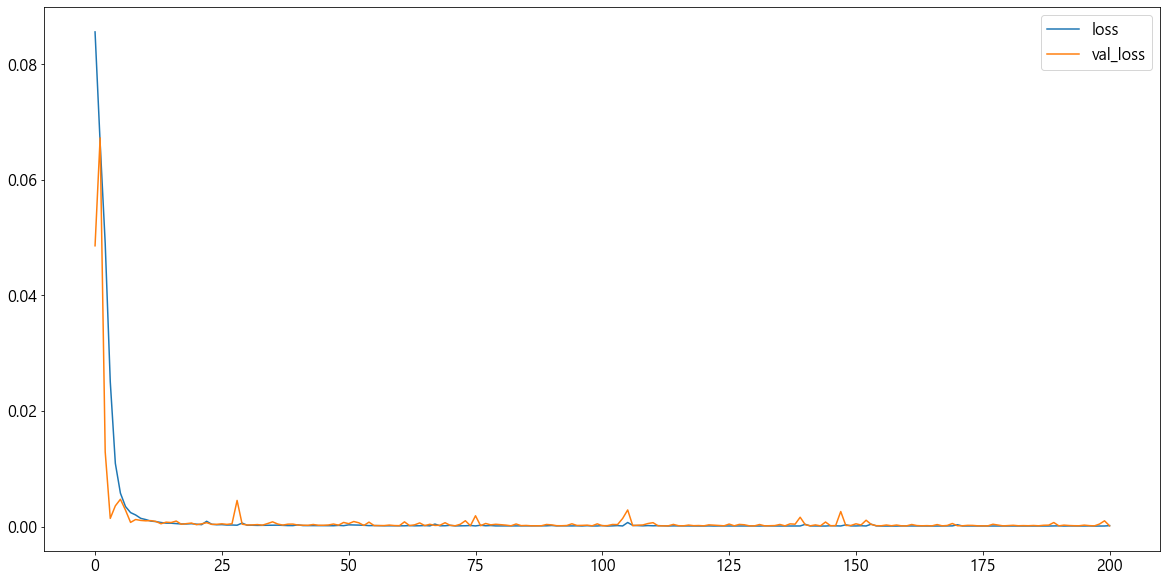

In [ ]:
# 손실률
plt.plot(loss_list[:-50], label='loss')
plt.plot(val_loss_list[:-50], label='val_loss')
plt.legend()
plt.show()

In [ ]:
# 모델을 가져온다.
best_model = load_model(path + '/best_model.h5')
best_model


In [ ]:
# 모델을 가져온다.
path2 = './model/LSTM/'
best_model2 = load_model(path2 + '/best_model.h5')
best_model2

In [ ]:
# 검증데이터를 통해 예측 결과를 가져온다.
pred = best_model.predict(test_data)
pred = pred.reshape(-1)
pred


3/3 [==============================] - 2s 30ms/step


array([0.68690723, 0.6777243 , 0.67560154, 0.66099685, 0.6589808 ,
       0.69463557, 0.6916017 , 0.693631  , 0.69931614, 0.6798139 ,
       0.6698362 , 0.6709274 , 0.65968996, 0.6829362 , 0.6785097 ,
       0.696195  , 0.7019458 , 0.6934052 , 0.70034176, 0.69925696,
       0.67987424, 0.67971724, 0.6734552 , 0.68192446, 0.6977875 ,
       0.6925333 , 0.68290967, 0.68481606, 0.6672293 , 0.66566503,
       0.6645775 , 0.64532775, 0.6227736 , 0.62226653, 0.6059977 ,
       0.61053145, 0.59449995, 0.5806424 , 0.57913   , 0.5671889 ,
       0.565568  , 0.5800068 , 0.5843514 , 0.59209186, 0.57156813,
       0.5590975 , 0.5492726 , 0.5632627 , 0.5635085 , 0.55207163,
       0.5781822 , 0.58393127, 0.5840796 , 0.57379013, 0.57319343,
       0.5663951 , 0.6025842 , 0.6257906 , 0.60929716, 0.6040431 ,
       0.6236566 , 0.6149352 , 0.6124368 , 0.6214663 , 0.6221574 ,
       0.6231342 , 0.61585176, 0.61505187, 0.6210604 , 0.6147504 ,
       0.61827743, 0.6177539 , 0.60802925, 0.5978569 , 0.58624

In [ ]:
# 검증데이터를 통해 예측 결과를 가져온다.
pred2 = best_model2.predict(test_data)
pred2 = pred2.reshape(-1)
pred2

3/3 [==============================] - 0s 16ms/step


array([0.6878107 , 0.6784366 , 0.6765697 , 0.6632282 , 0.65976685,
       0.69279957, 0.6933442 , 0.691962  , 0.69786614, 0.68148535,
       0.67016727, 0.6718098 , 0.6623216 , 0.68111116, 0.6806679 ,
       0.69368434, 0.70115274, 0.69300526, 0.69848126, 0.69887966,
       0.6812904 , 0.6793876 , 0.674989  , 0.68152106, 0.6966718 ,
       0.6930906 , 0.6828848 , 0.6845782 , 0.66964495, 0.6656879 ,
       0.66600704, 0.64766943, 0.6237489 , 0.6222072 , 0.6080022 ,
       0.6097003 , 0.5964401 , 0.57972646, 0.5785191 , 0.5676263 ,
       0.5644228 , 0.58010817, 0.58601946, 0.5924523 , 0.57265824,
       0.55734754, 0.5488066 , 0.56315196, 0.56565225, 0.5520988 ,
       0.5773853 , 0.58631945, 0.5842057 , 0.5740277 , 0.57284975,
       0.5672237 , 0.6016899 , 0.628462  , 0.6112325 , 0.6026453 ,
       0.6229133 , 0.6174475 , 0.612077  , 0.6213893 , 0.6232256 ,
       0.6235728 , 0.6167267 , 0.61501247, 0.62144923, 0.61631626,
       0.6179059 , 0.6186719 , 0.6089504 , 0.5974942 , 0.58606

In [ ]:
# 원래 결과를 1차원으로 변환한다.
y_test2 = y_test.reshape(-1)
# 20일치를 가지고 21일째를 예측하기 떄문에
# 앞선 20일은 예측하지 않는다.
y_test2 = y_test2[20:]
y_test2

array([0.68087855, 0.67829457, 0.66408269, 0.66149871, 0.69509044,
       0.69379845, 0.69638243, 0.70155039, 0.68346253, 0.67312661,
       0.67312661, 0.6627907 , 0.68346253, 0.68087855, 0.69767442,
       0.70413437, 0.69638243, 0.70284238, 0.70155039, 0.68346253,
       0.68217054, 0.67571059, 0.68346253, 0.69896641, 0.69509044,
       0.68604651, 0.6873385 , 0.67054264, 0.66795866, 0.66666667,
       0.64857881, 0.62661499, 0.62403101, 0.60852713, 0.61111111,
       0.59689922, 0.58268734, 0.58010336, 0.56847545, 0.56589147,
       0.57881137, 0.58397933, 0.59173127, 0.57364341, 0.56072351,
       0.5503876 , 0.5620155 , 0.56330749, 0.55297158, 0.57622739,
       0.58268734, 0.58397933, 0.5749354 , 0.57364341, 0.56718346,
       0.5994832 , 0.62403101, 0.61111111, 0.60594315, 0.62273902,
       0.61627907, 0.61369509, 0.62144703, 0.62273902, 0.62403101,
       0.61757106, 0.61627907, 0.62144703, 0.61627907, 0.61886305,
       0.61886305, 0.60981912, 0.5994832 , 0.5878553 , 0.59819

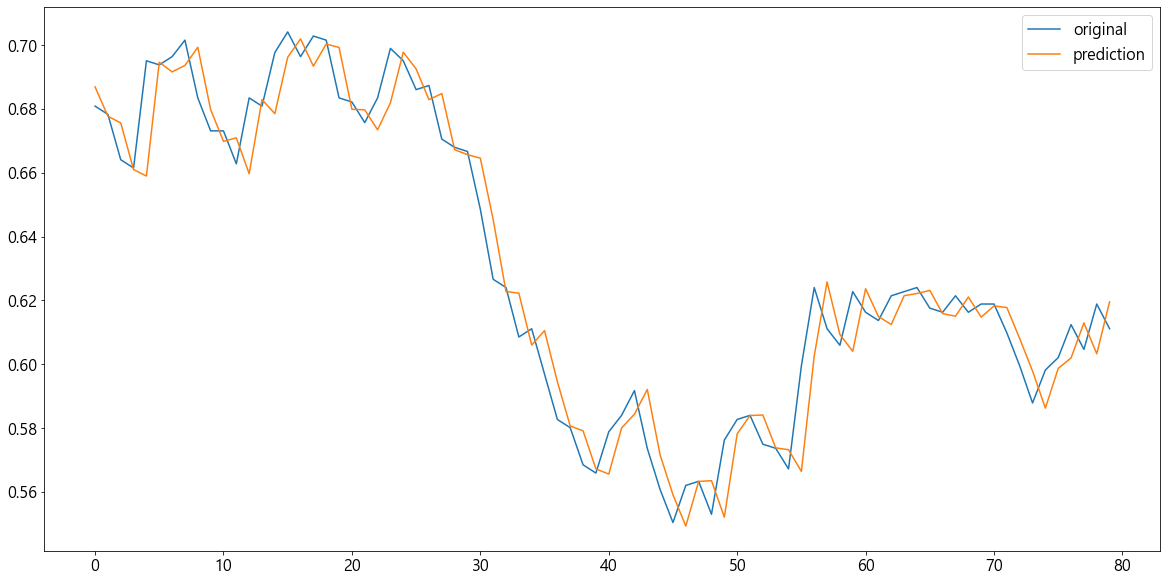

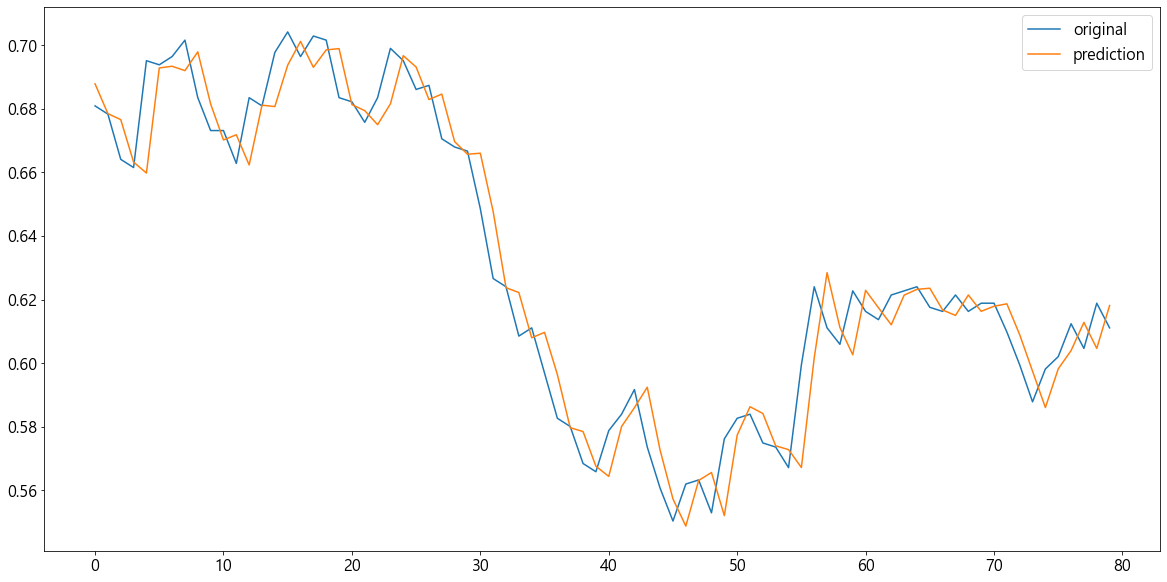

In [ ]:
# 양방향 LSTM
plt.plot(y_test2, label = 'original')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()
# LSTM
plt.plot(y_test2, label = 'original')
plt.plot(pred2, label='prediction')
plt.legend()
plt.show()
